# Exploratory Data Analysis of RHoMIS Data

Exploring the RHoMIS data set, and other data sources it could potentially be merged with. Assessing coverage and potential for a farm-size mapping.

In [85]:
# Setup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from farmsize import data_prep, db_scan, mapping
from shapely.geometry import Point
import math

In [2]:
# Reading in Data Sources
country_mapping = data_prep.load_json("./data/country_mappings.json")

ipums_terra = mapping.read_geo_csv("./data/ipums/processed/ipums_terra_merged.csv")
ipums_terra = ipums_terra.loc[ipums_terra["iso_2"].isin(country_mapping["iso_2"]),:]
ipums_terra = ipums_terra.merge(country_mapping, left_on="iso_2", right_on="iso_2", how="left")

# Loading RHoMIS Indicators
indicator_data = pd.read_csv("./data/RHoMIS_Indicators.csv", encoding="latin")
countries_iso_2 = country_mapping["iso_2"].to_list()
indicator_data = data_prep.subset_data(indicator_data, complete_gps=True, countries=countries_iso_2) # Subsetting data bas

# World Shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [3]:
# Spatially joining the household survey, the world shapefile, and the ipums terra data
indicator_data["geometry"] = [Point(xy) for xy in zip(indicator_data["GPS_LON"], indicator_data["GPS_LAT"])]
geo_indicator = gpd.GeoDataFrame(indicator_data)
geo_indicator = geo_indicator.sjoin(world, how="left", op="within")
geo_indicator = geo_indicator.rename(columns={"index_right":"index_world_shapefile"})
geo_indicator = geo_indicator.sjoin(ipums_terra, how="left", op="within")
geo_indicator = geo_indicator.rename(columns={"index_right":"index_ipums_terra"})



22

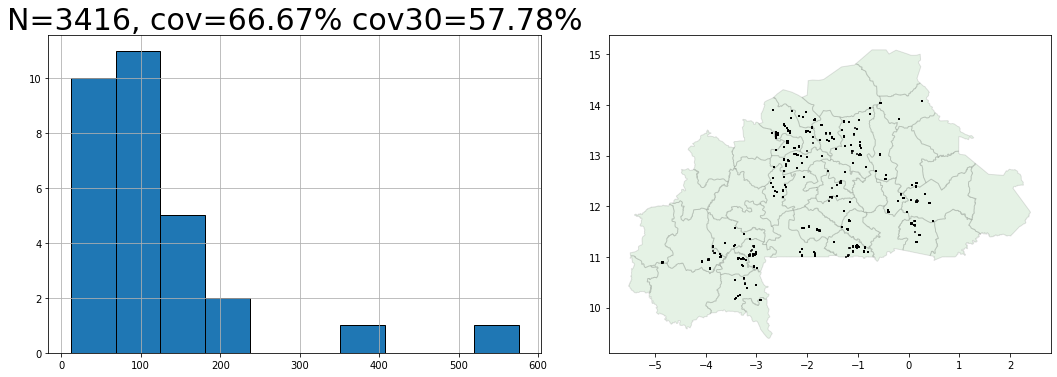

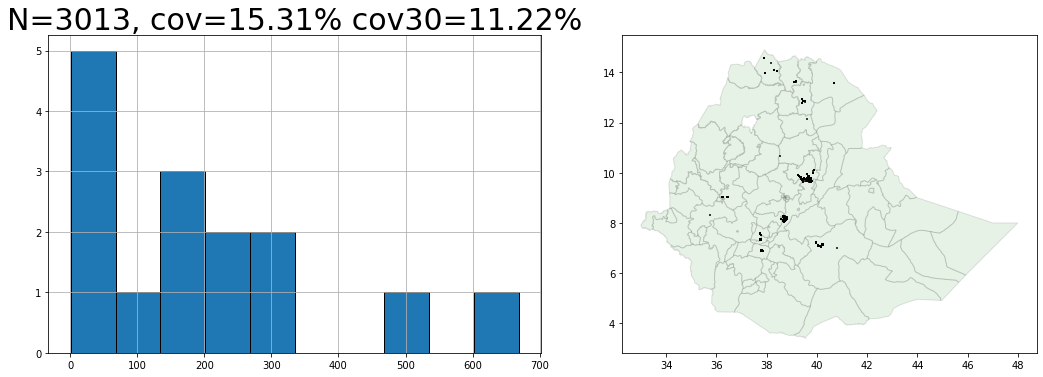

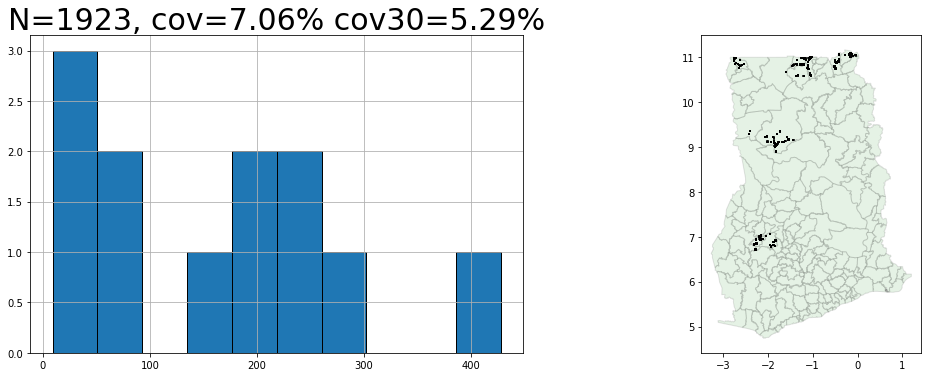

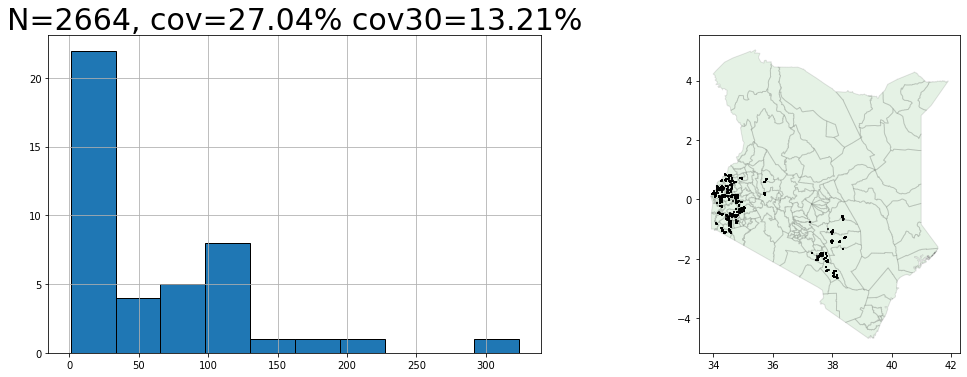

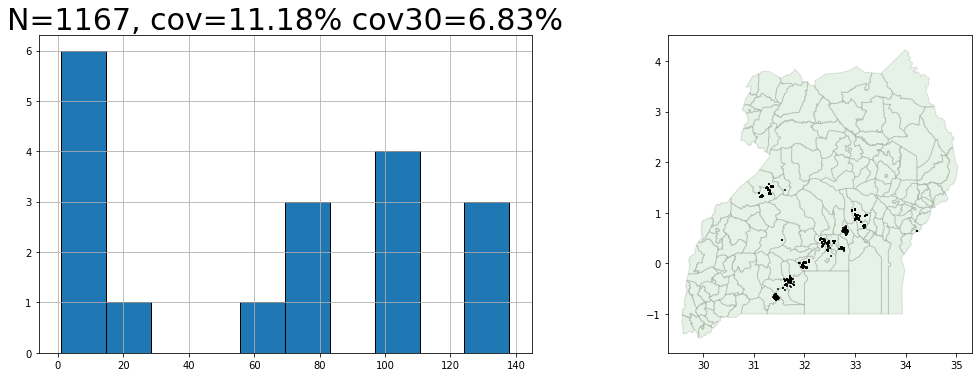

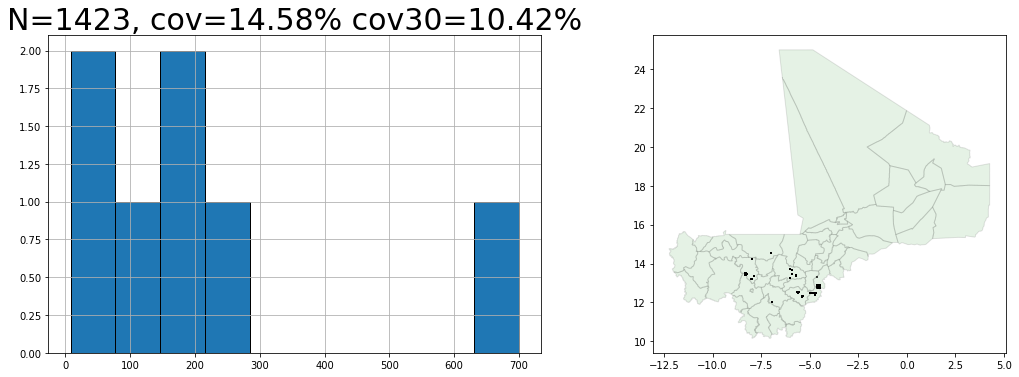

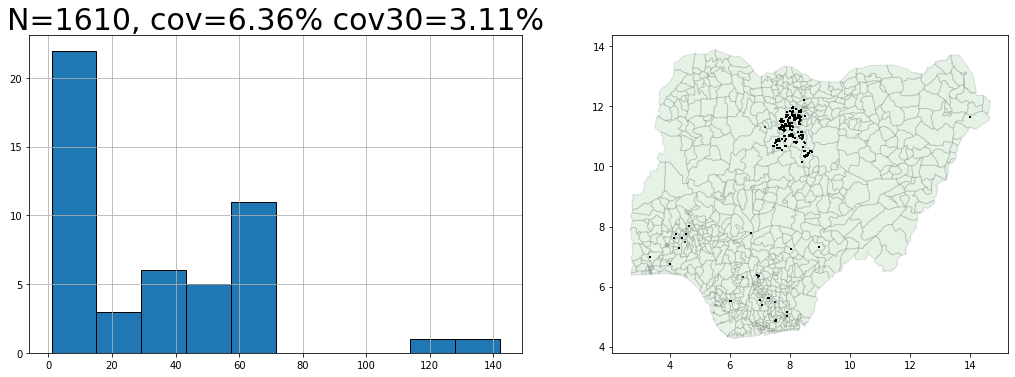

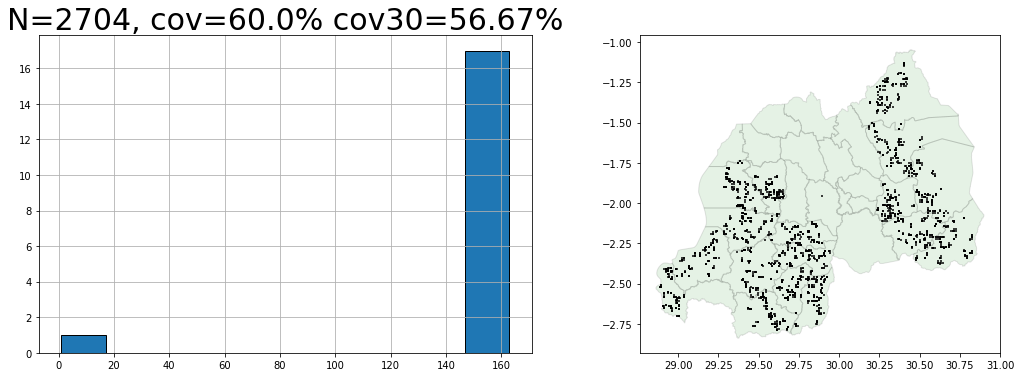

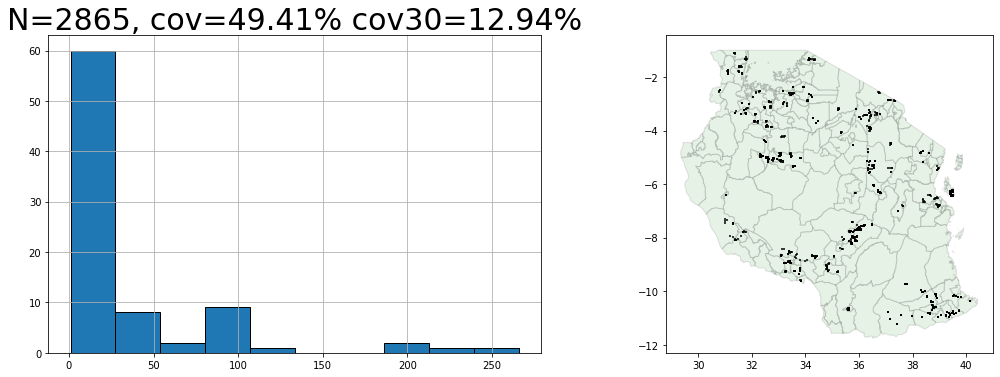

In [148]:
countries=geo_indicator.loc[geo_indicator["iso_3"].notna(),"iso_3"].unique()
# Counts per subnational unit
counts_per_subnational_unit = geo_indicator.groupby(["iso_3", "GEOID"]).size().reset_index(name="counts")
counts_per_subnational_unit.to_csv("./outputs/exploratory/hhs_per_unit.csv")



for country in countries:

    number_rhomis_subnational_region = len(geo_indicator.loc[geo_indicator["iso_3"]==country,"GEOID"].unique())
    number_total_subnational_region = len(ipums_terra.loc[ipums_terra["iso_3"]==country,"GEOID"].unique())

    counts_30 = geo_indicator.loc[geo_indicator["iso_3"]==country,"GEOID"].value_counts()
    counts_30 = counts_30[counts_30>30].count() 
    cov30 = str(round(100*counts_30/number_total_subnational_region,2))+"%"

    coverage = str(round(100*number_rhomis_subnational_region/number_total_subnational_region,2))+"%"
    N=str(geo_indicator.loc[geo_indicator["iso_3"]==country,:].shape[0])


    fig, ax = plt.subplots(1,2,figsize=(15,5))
    fig.tight_layout()
    ax[0].set_title("N="+N+", cov="+coverage+", cov30="+cov30, fontsize=30)
    counts_per_subnational_unit.loc[counts_per_subnational_unit["iso_3"]==country,"counts"].hist(ax=ax[0], edgecolor="black")
    ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[1], color="green", edgecolor="black", alpha=0.1)
    geo_indicator.loc[geo_indicator["iso_3"]==country,:].plot(ax=ax[1], marker=0, color='black', markersize=5)
    fig.savefig('./outputs/exploratory/map_per_country/'+country+'.png')



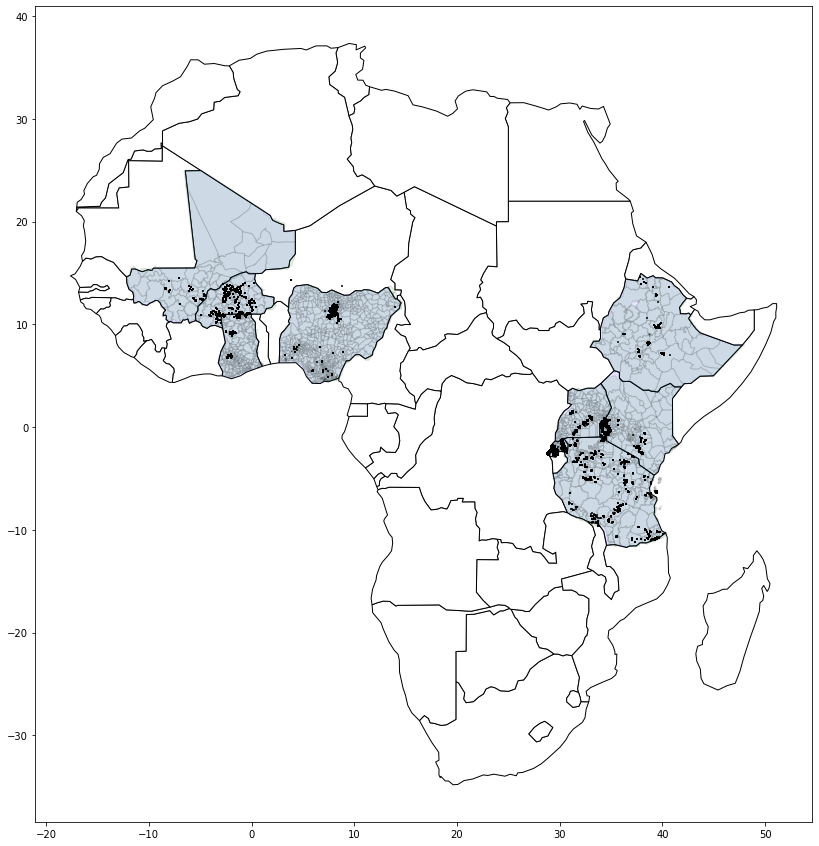

In [5]:
# Plot the points on a map
#same as
#fig= plt.figure()
#ax=fig.add_subplot()
fig, ax =  plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
#Plot map layer
world.loc[world["continent"]=="Africa",].plot(ax=ax,color="white", edgecolor="black")

world.loc[world["iso_a3"].isin(country_mapping["iso_3"]),].plot(ax=ax,color="blue", edgecolor="black", alpha=0.1)
ipums_terra .plot(ax=ax, color="green", edgecolor="black", alpha=0.1)
#Plot Points
geo_indicator.plot(ax=ax, marker=0, color='black', markersize=5)

fig.show()
fig.savefig('./outputs/exploratory/map.png')


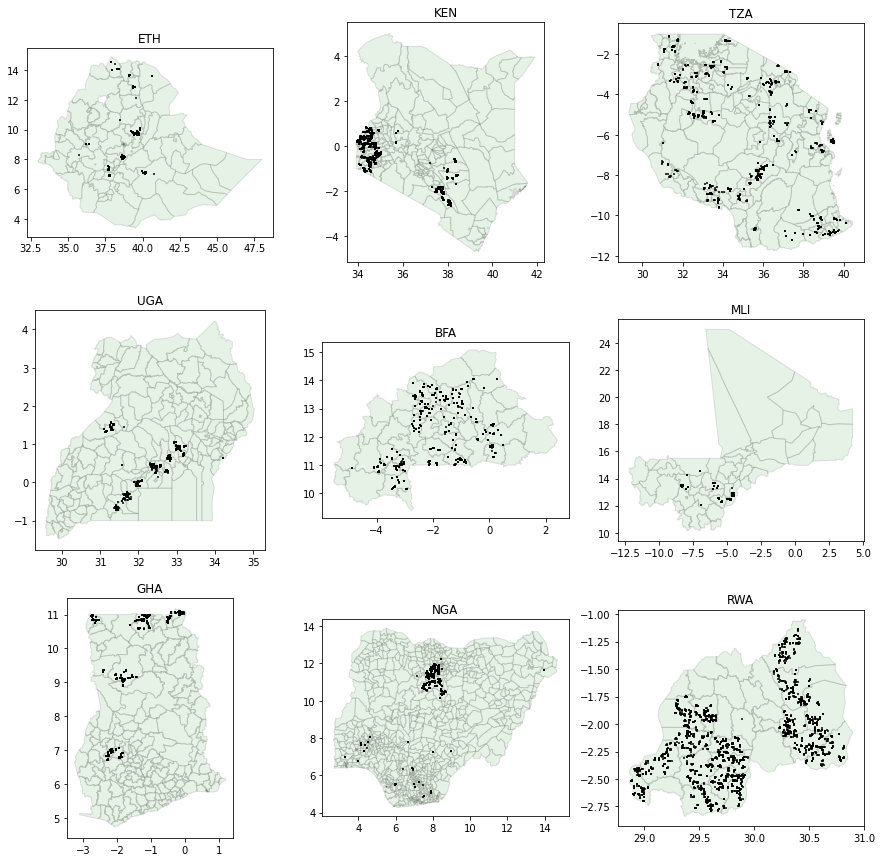

In [9]:
fig, ax =  plt.subplots(3,3,figsize=(15,15))

ax = ax.ravel()
# Per country map
index=0
for country in country_mapping["iso_3"]:
    ax[index].set_aspect('equal')
    #Plot map layer
    ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[index], color="green", edgecolor="black", alpha=0.1)
    #Plot Points
    geo_indicator.loc[geo_indicator["iso_3"]==country,:].plot(ax=ax[index], marker=0, color='black', markersize=5)
    ax[index].set_title(country)
    index=index+1
# fig.suptitle("RHoMIS Points Over 9 Countries \n Level 2 Subnational Areas")
# fig.show()
fig.savefig('./outputs/exploratory/map_per_country/all_countries.png')

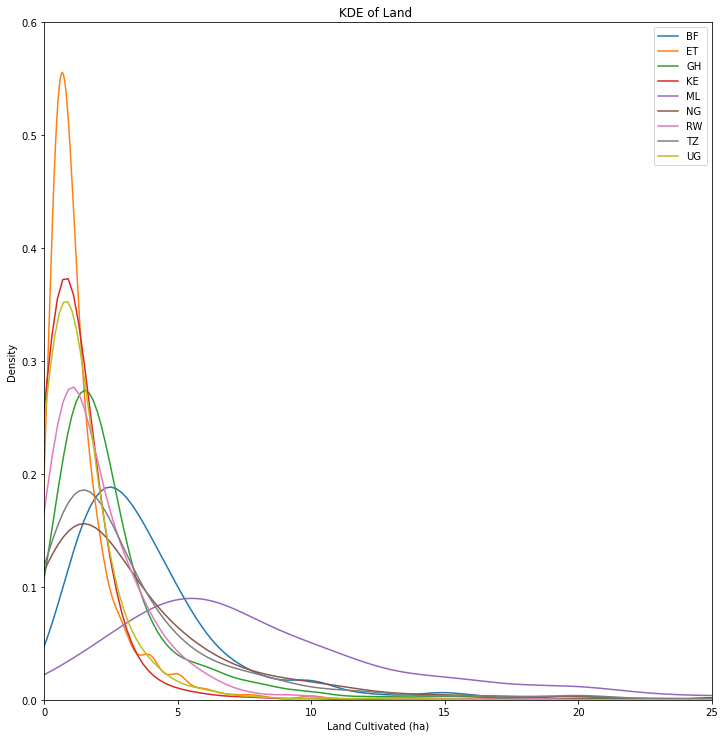

In [10]:
# Grouping by 
row_subsets = indicator_data["LandCultivated"].notna() & indicator_data["LandCultivated"].between(0.05,100)
column_subsets= ["ID_COUNTRY", "LandCultivated"]
grouping="ID_COUNTRY"

fig, ax = plt.subplots(figsize=(10,10))
plt.tight_layout()
ax.set_title("KDE of Land ")
ax.set_xlabel("Land Cultivated (ha)")
ax.set_ylabel("Density")
ax.set_xlim([0,25])
ax.set_ylim([0,0.6])
indicator_data.loc[row_subsets,:].groupby("ID_COUNTRY")["LandCultivated"].plot(kind="kde", ax=ax, legend=True)
fig.savefig("./outputs/exploratory/land_size_kde_all_countries.png", bbox_inches="tight")

# Clustering Households Spatially

In [11]:
cluster_labels = db_scan.cluster_gps_points(indicator_data, "GPS_LON", "GPS_LAT", epsilon=0.1)